# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds a classifier which predicts whether or not a film will be "good" or "bad" based on the plot synopsis, the popularity of the leading actors, and other variables such as genre. "Good" films are those which perform better than the mean of all of the IMdB critic's rating scores in the dataset, while "bad" films score lower than that mean.

In [114]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)

import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle

import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import XGBClassifier
from patsy import dmatrices

## Get the data

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

One really nice thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to another API in order to supplement our data with more features. A key to the OMdB API cost a minimum of one dollar. Here we parse out those IMdB ID's:

In [73]:
imdb.shape

(5043, 28)

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

Here we make the API calls, and persist our data to little .txt files:

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

This is what we want our eventual pandas dataFrame to look like:

In [5]:
df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

This is where we frankenstein together the kaggle dataset with what we got from OMdB:

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r") # Open up each movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text) # Coerce string to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'") # Cleanup
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True) # Add to dataframe

Here's our beautiful new dataFrame:

In [7]:
df.iloc[:3,:]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8


## Munging and EDA

We drop datapoints with null 'imdbRating' values, since that is our independent / target variable. We also convert these into binary; we are only concerned with whether or not a film's 'imbdRating' is above the mean (1) or below the mean (0). This binary value is saved into a new column called 'binary_target'.

Null values in the 'actor facebook likes' column were imputed from the column mean.

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [9]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8,1


### One-hot encoding Genres

In [10]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [11]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


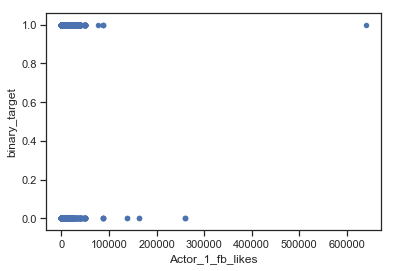

In [12]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='binary_target')

In [13]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

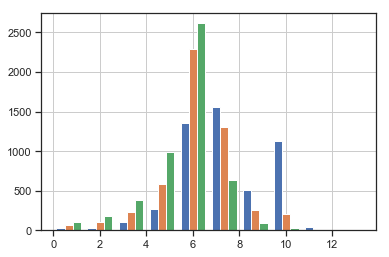

In [14]:
pd.Series(actor_likes).hist()

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [15]:
main_df = main_df.join(actor_likes)
main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.908755,6.842683,6.752270
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.596660,8.517393,6.908755
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.305741,5.976351,5.087596


### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [16]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.589224
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Mon, 25 Feb 2019   Pseudo R-squ.:                  0.1465
Time:                        10:04:14   Log-Likelihood:                -2374.0
converged:                       True   LL-Null:                       -2781.4
                                        LLR p-value:                2.437e-157
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  82.3166      6.980     11.794      0.000      68.637   

0.6974206349206349

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [17]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Mon, 25 Feb 2019   Pseudo R-squ.:                  0.1468
Time:                        10:04:14   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2779.9
                                        LLR p-value:                3.402e-164
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  87.8001      6.935     12.660      0.000      74.207   

0.7043650793650794

In [18]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'Actor_1_fb_likes_logged',
       'Actor_2_fb_likes_logged', 'Actor_3_fb_likes_logged'],
      dtype='object')

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserW

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])


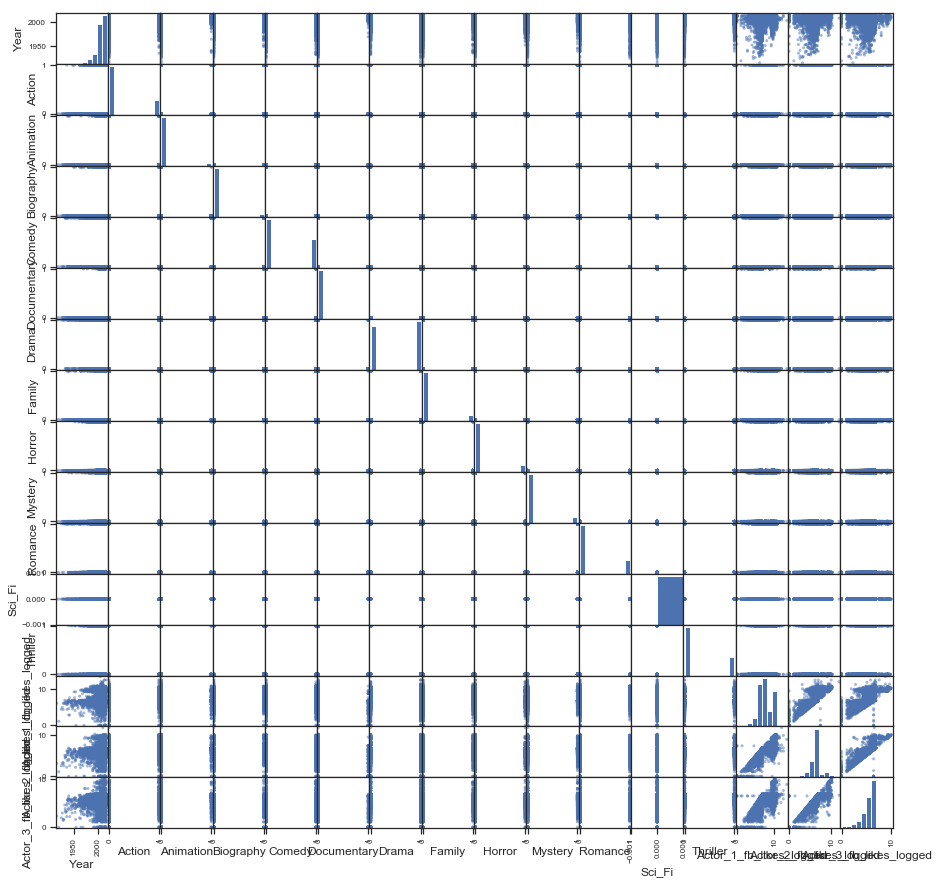

In [19]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

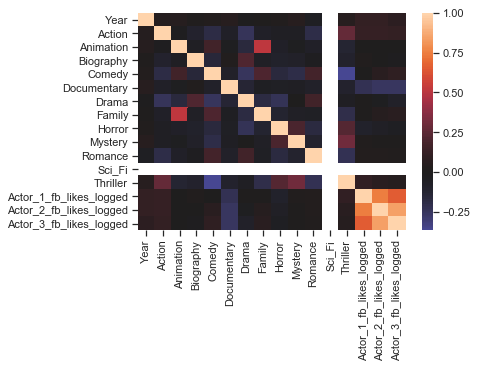

In [20]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [22]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [23]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [24]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [25]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [26]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [121]:
NUM_TOPICS = 200 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [122]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(190, '0.081*"club" + 0.024*"work" + 0.023*"ugly" + 0.021*"cocaine"'),
 (146, '0.154*"game" + 0.069*"final" + 0.061*"involve" + 0.048*"mob"'),
 (75, '0.072*"full" + 0.063*"prisoner" + 0.052*"law" + 0.038*"dinner"'),
 (168, '0.048*"gold" + 0.022*"author" + 0.022*"sinister" + 0.021*"extremely"'),
 (113, '0.138*"army" + 0.050*"defeat" + 0.041*"obsession" + 0.035*"lead"'),
 (53, '0.105*"ray" + 0.042*"chaos" + 0.026*"longer" + 0.022*"environment"'),
 (95, '0.029*"team" + 0.028*"kill" + 0.027*"undercover" + 0.026*"government"'),
 (124, '0.271*"john" + 0.023*"rick" + 0.022*"mysterious" + 0.018*"mixed"'),
 (77, '0.052*"van" + 0.034*"musical" + 0.033*"roll" + 0.025*"walker"'),
 (32, '0.043*"employee" + 0.036*"josh" + 0.033*"code" + 0.029*"know"'),
 (143, '0.090*"zombie" + 0.070*"gangster" + 0.027*"study" + 0.025*"take"'),
 (10, '0.038*"hell" + 0.026*"loose" + 0.025*"businessman" + 0.025*"one"'),
 (6, '0.049*"horror" + 0.047*"prevent" + 0.038*"way" + 0.027*"shoot"'),
 (120,
  '0.247*"jack" + 0.

In [123]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
128   -0.218213 -0.094646       1        1  1.610668
117   -0.221252 -0.016403       2        1  1.560120
173   -0.219915 -0.101539       3        1  1.480067
159   -0.179127 -0.100272       4        1  1.253316
131   -0.016450  0.051016       5        1  1.158911
160   -0.126110 -0.005165       6        1  1.096321
114   -0.146138 -0.067949       7        1  1.095568
169   -0.193802 -0.079812       8        1  1.060413
161   -0.165088  0.110205       9        1  1.057057
158   -0.104257  0.171666      10        1  0.945514
51    -0.123308 -0.023239      11        1  0.921887
177   -0.154637  0.086899      12        1  0.878782
15    -0.033314 -0.149145      13        1  0.854264
50    -0.138140  0.022928      14        1  0.836375
100   -0.182894  0.043988      15        1  0.801088
175   -0.081288 -0.002135      16        1  0.791087
67    -0.113553 -0.146558      17        1  0.777441
187   -0.067534 -0.031718      18        1  0.774188
122   -0.128367  0.043816      19        1  0.760706
7     -0.072203  0.061546      20        1  0.751704
156   -0.145690 -0.055578      21        1  0.741386
35    -0.043817  0.009494      22        1  0.724799
151   -0.002326 -0.131619      23        1  0.719556
20    -0.069525  0.032041      24        1  0.706931
79    -0.115358  0.026442      25        1  0.701685
103   -0.049927 -0.031237      26        1  0.696877
95     0.034479  0.149754      27        1  0.696397
130    0.036789  0.007684      28        1  0.687247
129   -0.101889  0.030163      29        1  0.678576
54     0.002293 -0.052093      30        1  0.678290
...         ...       ...     ...      ...       ...
92     0.087620 -0.001837     171        1  0.335838
157    0.088200 -0.057131     172        1  0.333892
147    0.073796  0.053906     173        1  0.330129
74     0.032839 -0.025272     174        1  0.329646
14     0.059017 -0.029295     175        1  0.326445
123    0.071825 -0.051040     176        1  0.321184
60     0.059802  0.039348     177        1  0.313420
116    0.067293  0.034838     178        1  0.313172
52     0.081171 -0.022933     179        1  0.310759
152    0.117401  0.002417     180        1  0.307991
99     0.054958  0.025735     181        1  0.304529
178    0.116636  0.038187     182        1  0.292343
115    0.089240 -0.026833     183        1  0.291183
163    0.078270  0.045898     184        1  0.285510
75     0.083471  0.079066     185        1  0.285432
143    0.048533  0.014810     186        1  0.285278
46     0.080176 -0.043268     187        1  0.277107
37     0.083834 -0.062180     188        1  0.275100
140    0.066006  0.046353     189        1  0.274520
55     0.101327  0.004354     190        1  0.271278
155    0.096582 -0.022079     191        1  0.268371
39     0.088249 -0.032415     192        1  0.267905
133    0.092569  0.002374     193        1  0.266928
150    0.093108  0.003052     194        1  0.248479
149    0.123040  0.005630     195        1  0.233599
63     0.127148  0.032788     196        1  0.229338
165    0.169889 -0.010010     197        1  0.215264
198    0.133595  0.000534     198        1  0.210140
184    0.127146  0.016771     199        1  0.205097
89     0.156626  0.015343     200        1  0.194929

[200 rows x 5 columns], topic_info=      Category         Freq            Term        Total  loglift  logprob
1149   Default  1062.000000          family  1062.000000  30.0000  30.0000
244    Default   823.000000          father   823.000000  29.0000  29.0000
359    Default   574.000000          school   574.000000  28.0000  28.0000
2124   Default   474.000000            film   474.000000  27.0000  27.0000
658    Default   506.000000            town   506.000000  26.0000  26.0000
544    Default   431.000000            team   431.000000  25.0000  25.0000
34     Default  1024.000000            love  1024.000000  24.0000  24

In [124]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [125]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.029045,0.016214,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.067576,0.000000,0.0,0.0,0.0,0.035019,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.000000,0.036518,0.0,0.0,0.0,0.000000,0.025017,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021866,0.110616,0.0,0.0


## Joining Topic-Modeled Synopses with Standard Features

In [126]:
df = main_df.join(tm)
len(df.columns)

217

## Model Building

In [127]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


train_test_split on X_scaled:

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

### Baselining:

In [129]:
dc = DummyClassifier().fit(X_train, y_train)

In [130]:
accuracy_score(y_test,dc.predict(X_test))

0.4732142857142857

Our baseline / dummy accuracy is 47%, roughly.

Dimensionality Reduction with SVD - For the PlotText Data:

In [141]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

0.29817867599543213


Next we'll try a simple Gaussian Naive Bayes Model:

In [142]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

              precision    recall  f1-score   support

           0       0.61      0.49      0.54       449
           1       0.65      0.75      0.69       559

   micro avg       0.63      0.63      0.63      1008
   macro avg       0.63      0.62      0.62      1008
weighted avg       0.63      0.63      0.63      1008

Test accuracy: 63.29%


__________

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [148]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 75.85%
Test accuracy: 68.75%


In [149]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7454888820714687


In [150]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

AUC: 0.7454888820714687


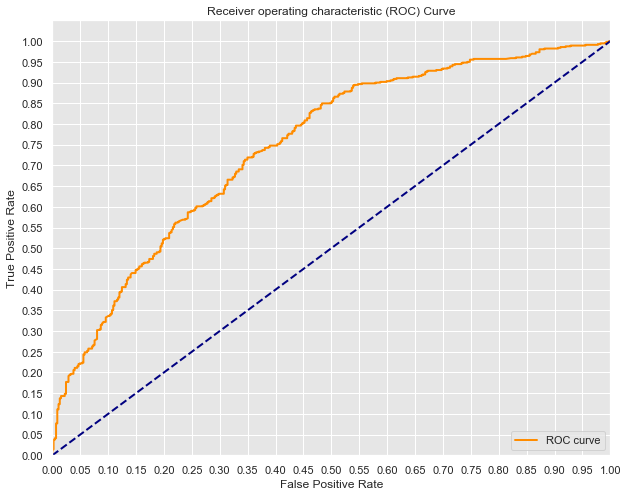

In [151]:
draw_roc_curve(fpr,tpr)

Looks like we're off to an okay start!

## Grid Searching for better parameters

In [157]:
# svd_components = [100,500,1000]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  67 out of  81 | elapsed:   17.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  76 out of  81 | elapsed:   18.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.6s f

{'classify__learning_rate': 0.1,
 'classify__max_depth': 3,
 'classify__n_estimators': 50,
 'classify__n_jobs': -1}

In [158]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

0.6755952380952381

In [159]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

AUC: 0.7476025036754306


<Figure size 432x288 with 0 Axes>

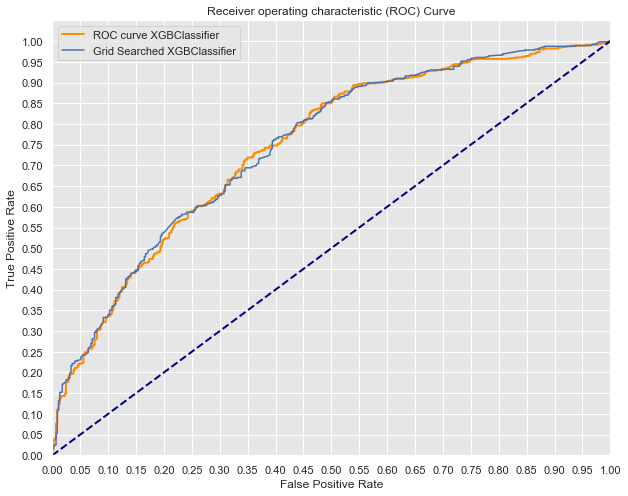

In [160]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.